# Importing Dependencies

In [29]:
#import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import seaborn as sb
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, cross_validate, learning_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier, StackingClassifier, BaggingClassifier
import xgboost as xgb
from pandas.plotting import scatter_matrix
from sklearn.model_selection import validation_curve


# Data Description and Exploration

In [15]:
# read data 

data = pd.read_csv('premier_train_dataset.csv')
data.drop(data.columns[0],axis=1,inplace=True)

data[40:50]



#HTGS       - Home Team Goals Scored (so far in the league)
#ATGS       - Away Team Goals Scored (so far in the league)
#HTGC       - Home Team Goals Conceded (so far in the league)
#ATGC       - Away Team Goals Conceded (so far in the league)
#FTHG       - Full Time Home Goals (in the match)
#FTAG       - Full Time Away Goals (in the match)
#FTR        - Full Time Result (H- Home Win; D - Draw; A - Away Win)
#HomeTeamLP - Home Team League Position
#AwayTeamLP - Away Team League Position
#HTFormPts  - Home Team sum of points in the last 5 games
#ATFormPts  - Away Team sum of points in the last 5 games
#HTGD       - Home Team Goal Diference (so far in the league)
#ATGD       - Away Team Goal Diference (so far in the league)
#MW         - Match Week
#HTGS       - Home Team Points (so far in the league)
#ATGS       - Away Team Points (so far in the league)

,HomeTeam,AwayTeam,HTGS,ATGS,HTGC,ATGC,FTHG,FTAG,FTR,HomeTeamLP,AwayTeamLP,HTFormPts,ATFormPts,HTGD,ATGD,MW,HTP,ATP
40,Coventry,Leeds,5,5,7,3,0,0,D,14.0,3.0,6,7,0,0,5.0,7,4
41,Ipswich,Aston Villa,4,4,6,5,1,2,A,18.0,6.0,4,5,-1,-1,5.0,4,4
42,Leicester,Southampton,3,7,1,8,1,0,H,8.0,15.0,8,3,3,-2,5.0,10,2
43,Liverpool,Man City,7,7,6,9,3,2,H,4.0,18.0,7,6,1,1,5.0,7,6
44,Man United,Sunderland,11,4,3,6,3,0,H,1.0,7.0,8,4,9,-6,5.0,8,1
45,Middlesbrough,Everton,8,7,7,7,1,2,A,12.0,13.0,5,4,-2,3,5.0,2,7
46,Newcastle,Chelsea,7,7,4,7,0,0,D,11.0,5.0,9,5,5,-2,5.0,10,3
47,Derby,Charlton,9,8,10,9,2,2,D,16.0,18.0,3,4,-1,-5,5.0,3,2
48,Tottenham,West Ham,7,5,6,8,1,0,H,10.0,9.0,7,2,0,-2,5.0,7,2
49,Arsenal,Coventry,9,5,6,7,2,1,H,2.0,14.0,7,6,5,-1,5.0,11,7


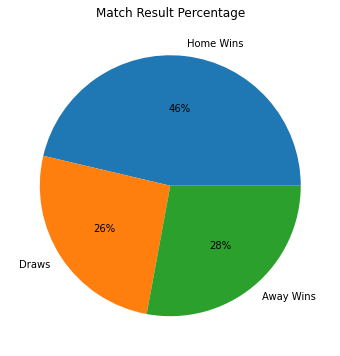

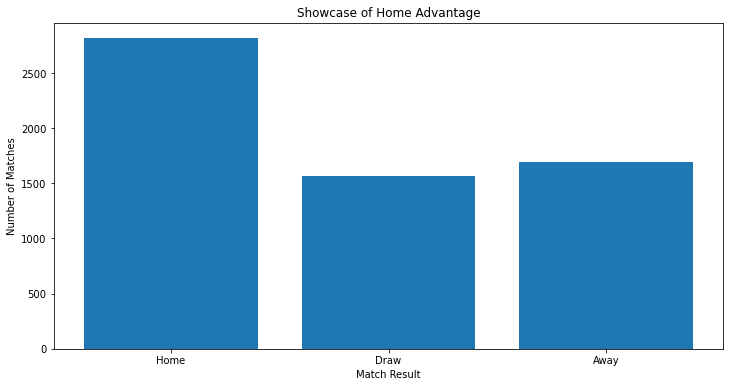

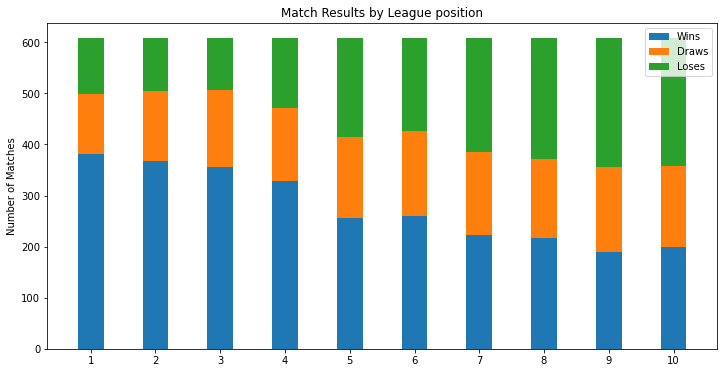

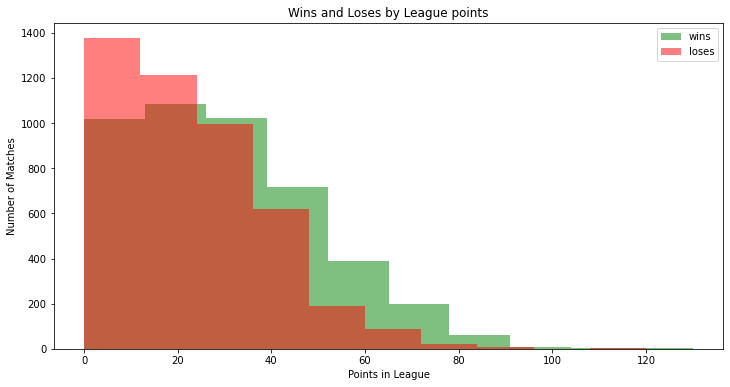

In [16]:

plt.rcParams["figure.figsize"] = (12, 6)
# Total number of matches.
n_matches = data.shape[0]

# Calculate H/D/A totals.
n_homewins = len(data[data.FTR == 'H'])
n_draws = len(data[data.FTR == 'D'])
n_awaywins = len(data[data.FTR == 'A'])

# Calculate H/D/A percentages.
home_win_rate = (float(n_homewins) / (n_matches)) * 100
draw_rate = (float(n_draws) / (n_matches)) * 100
away_win_rate = (float(n_awaywins) / (n_matches)) * 100

#Plot pie chart
pie_y = [n_homewins, n_draws, n_awaywins]
pie_labels = ["Home Wins", "Draws", "Away Wins"]
plt.pie(pie_y, labels = pie_labels, autopct='%1.0f%%')
plt.title("Match Result Percentage")
plt.show()

#Plot bar chart
bar_x = np.array(["Home", "Draw", "Away"])
bar_y = np.array([n_homewins, n_draws, n_awaywins])
plt.bar(bar_x,bar_y)
plt.xlabel("Match Result")
plt.ylabel("Number of Matches")
plt.title("Showcase of Home Advantage")
plt.show()

#Plot Bar Chart of League position W/D/L #######################################


#labels = np.flip(labels)
labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']

wins = np.zeros(18)
draws = np.zeros(18)
loses = np.zeros(18)


for index, row in data.iterrows():
    if row['FTR']=='H':
        wins[int(row['HomeTeamLP'])-1]+=1
        loses[int(row['AwayTeamLP'])-1]+=1
    elif row['FTR']=='A':
        loses[int(row['HomeTeamLP'])-1]+=1
        wins[int(row['AwayTeamLP'])-1]+=1
    else:
        draws[int(row['HomeTeamLP'])-1]+=1
        draws[int(row['AwayTeamLP'])-1]+=1

labels = labels[0:10]
wins = wins[0:10]
draws = draws[0:10]
loses = loses[0:10]

fig, ax = plt.subplots()
width = 0.4

ax.bar(labels, wins, width, label='Wins')
ax.bar(labels, draws, width, bottom=wins,
       label='Draws')
ax.bar(labels, loses, width, bottom=wins+draws,
       label='Loses')

ax.set_ylabel('Number of Matches')
ax.set_title('Match Results by League position')
ax.legend()

plt.show()


# Points in league vs wins
def gen_hist():
    hist_wins = []
    hist_loses = []

    for index, row in data.iterrows():
        if row['FTR']=='H':
            hist_wins.append(row['HTP'])
            hist_loses.append(row['ATP'])
        elif row['FTR']=='A':
            hist_wins.append(row['ATP'])
            hist_loses.append(row['HTP'])


    plt.hist(hist_wins, color='green', alpha=0.5, label='wins')
    plt.hist(hist_loses, color='red', alpha=0.5, label='loses')
    plt.legend(loc='upper right')
    plt.xlabel("Points in League")
    plt.ylabel("Number of Matches")
    plt.title("Wins and Loses by League points")
    plt.show()

gen_hist()





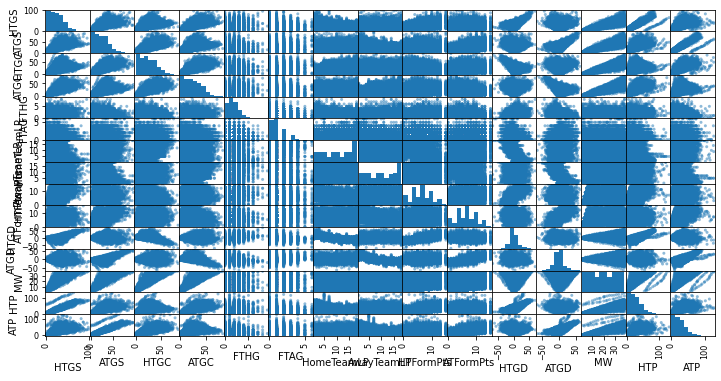

In [17]:
# Scatterplot Matrix

scatter_matrix(data)
plt.show()

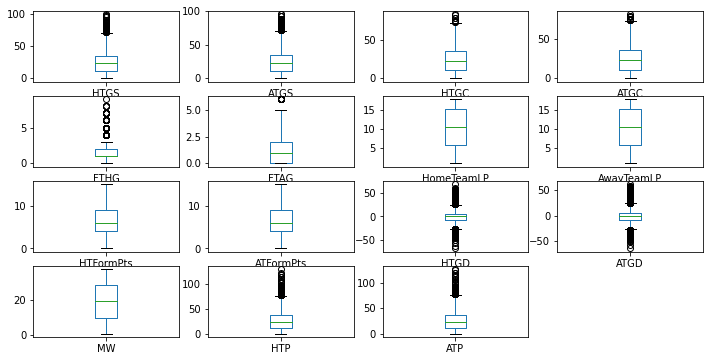

In [18]:
# Box and Whisker Plots
data.plot(kind='box', subplots=True, layout=(4, 4), sharex=False, sharey=False)
plt.show()

In [31]:
def val_curve_acc(p_range, param, X, y):
    
    
    train_scores, valid_scores = validation_curve(SVC(), X, y.ravel(), param_name = param, 
                                              param_range = p_range, cv=10, scoring="accuracy")


    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)
    test_scores_std = np.std(valid_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel(param)
    plt.ylabel("Score")

    plt.plot(c_range, train_scores_mean,
         label = "Training Score", color = 'b')
    plt.plot(c_range, test_scores_mean,
       label = "Cross Validation Score", color = 'g')

    plt.legend(loc="best")
    plt.show()

# Data Preparation

In [20]:
# Separate into feature set and target variable
feature_set = data.drop(['HomeTeam','AwayTeam','FTR', 'FTHG', 'FTAG','MW'],1)
target_set = data['FTR']

cols = [['HTGS','ATGS','HTGC','ATGC','HomeTeamLP','AwayTeamLP', 'HTFormPts','ATFormPts','HTGD','ATGD','HTP','ATP']]
for col in cols:
    feature_set[col] = scale(feature_set[col])
  
    
feature_set[40:50]

,HTGS,ATGS,HTGC,ATGC,HomeTeamLP,AwayTeamLP,HTFormPts,ATFormPts,HTGD,ATGD,HTP,ATP
40,-1.139955,-1.147697,-1.067294,-1.309120,0.654571,-1.324887,-0.069788,0.168843,-0.019236,0.009430,-1.010783,-1.160716
41,-1.199019,-1.206839,-1.128677,-1.185829,1.374374,-0.785035,-0.632534,-0.399262,-0.089016,-0.060746,-1.171777,-1.160716
42,-1.258084,-1.029413,-1.435591,-1.000893,-0.425134,0.834522,0.492958,-0.967368,0.190106,-0.130921,-0.849789,-1.268505
43,-1.021826,-1.029413,-1.128677,-0.939248,-1.144937,1.374374,0.211585,-0.115210,0.050545,0.079605,-1.010783,-1.052927
44,-0.785568,-1.206839,-1.312825,-1.124184,-1.684789,-0.605084,0.492958,-0.683315,0.608789,-0.411623,-0.957119,-1.322399
45,-0.962761,-1.029413,-1.067294,-1.062539,0.294669,0.474620,-0.351161,-0.683315,-0.158797,0.219956,-1.279106,-0.999033
46,-1.021826,-1.029413,-1.251443,-1.062539,0.114719,-0.964986,0.774331,-0.399262,0.329667,-0.130921,-0.849789,-1.214610
47,-0.903697,-0.970271,-0.883146,-0.939248,1.014472,1.374374,-0.913907,-0.683315,-0.089016,-0.341447,-1.225442,-1.268505
48,-1.021826,-1.147697,-1.128677,-1.000893,-0.065232,-0.245183,0.211585,-1.251421,-0.019236,-0.130921,-1.010783,-1.268505
49,-0.903697,-1.147697,-1.128677,-1.062539,-1.504838,0.654571,0.211585,-0.115210,0.329667,-0.060746,-0.796125,-0.999033


# Spliting into Train and Test sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(feature_set, target_set, test_size = 0.25, random_state = 23, stratify = target_set)

# Base Models

In [22]:
def basic_train_and_test(clf, X_train, X_test, y_train, y_test):

    clf.fit(X_train, y_train)

    y_pred_train = clf.predict(X_train)
    acc_train = sum(y_train == y_pred_train) / float(len(y_pred_train))
    f1_train = f1_score(y_train, y_pred_train, average='weighted')

    print("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1_train , acc_train))

    y_pred_test = clf.predict(X_test)
    acc_test = sum(y_test == y_pred_test) / float(len(y_pred_test))
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1_test , acc_test))
    
    return y_pred_test

def get_confusion_matrix(clf, y_pred_test, y_test):
    cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
    return cm

def display_cm(clf, cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    


## Logistic Regression

In [39]:
def costFunction(theta, X, y):
    """
    Takes in numpy array theta, x and y and return the logistic regression cost function and gradient
    """
    
    #number of training examples 
    m=len(y)
    
    #vector of the model predictions for all training examples
    z = np.dot(X, theta)
    h = 1/ ( 1 + np.exp(-z))
         
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))

    #cost function
    cost = 1/m * sum(error)
       
    #vector of gradients of all model parameters theta   
    grad = 1/m * np.dot(X.transpose(),(h - y))
    
    return cost[0] , grad

In [40]:
def gradientDescent(X,y,theta,alpha,num_iters):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    #number of training examples
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        cost, grad = costFunction(theta, X, y)
        # neste caso o grad já esta a dividir por m
        theta = theta - alpha * grad
        J_history.append(cost)
    
    return theta , J_history

In [43]:
lr=[0.01, 0.1, 0.5, 1]
print(y_train.ravel())
# lr -learning rate (alpha)
for i in lr:
    theta = np.zeros((X_train.shape[1],1))
    theta, J_history2 = gradientDescent(X_train, y_train, theta ,i , 1000)
    plt.plot(J_history2)
    
plt.legend(("0.01", "0.1", "0.5", "1"))
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

['H' 'H' 'H' ... 'A' 'H' 'D']


TypeError: bad operand type for unary -: 'str'

F1 score and accuracy score for training set: 0.6325 , 0.6268.
F1 score and accuracy score for test set: 0.6536 , 0.6474.


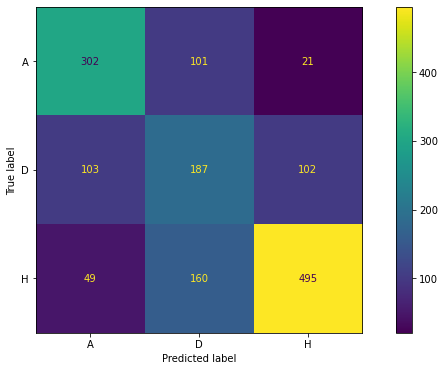

In [23]:
# Logistic Regression
clf_log = LogisticRegression(random_state=24, max_iter=1000, class_weight='balanced')
y_pred_test = basic_train_and_test(clf_log, X_train, X_test, y_train, y_test)
cm = get_confusion_matrix(clf_log, y_pred_test, y_test)
display_cm(clf_log, cm)

## SVM

F1 score and accuracy score for training set: 0.5824 , 0.6336.
F1 score and accuracy score for test set: 0.5678 , 0.6211.


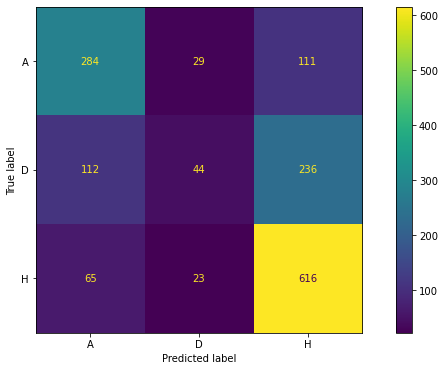

In [24]:
# SVM
clf_svm = SVC(kernel="rbf")
y_pred_test = basic_train_and_test(clf_svm, X_train, X_test, y_train, y_test)
cm = get_confusion_matrix(clf_svm, y_pred_test, y_test)
display_cm(clf_svm, cm)

## Neural Network

F1 score and accuracy score for training set: 0.6708 , 0.6851.
F1 score and accuracy score for test set: 0.6534 , 0.6697.


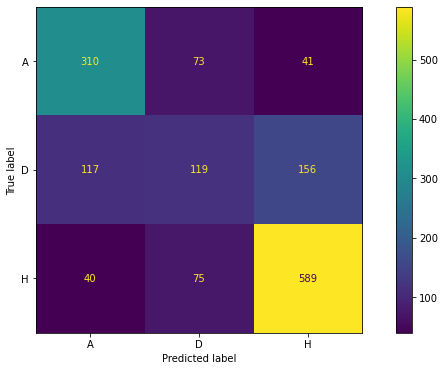

In [25]:
# NN
clf_nn = MLPClassifier(hidden_layer_sizes=(12,12), max_iter=750)
y_pred_test = basic_train_and_test(clf_nn, X_train, X_test, y_train, y_test)
cm = get_confusion_matrix(clf_nn, y_pred_test, y_test)
display_cm(clf_nn, cm)

## XGBoost

F1 score and accuracy score for training set: 0.9829 , 0.9829.
F1 score and accuracy score for test set: 0.6039 , 0.6171.


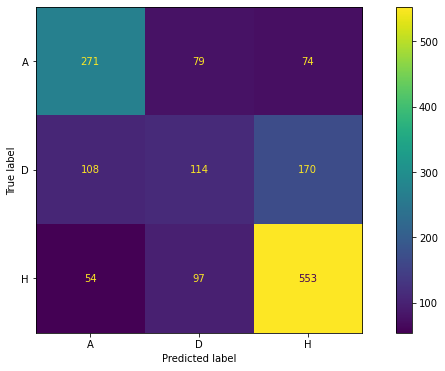

In [26]:
# XGBoost
xgb_clf = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss')
y_pred_test = basic_train_and_test(xgb_clf, X_train, X_test, y_train, y_test)
cm = get_confusion_matrix(xgb_clf, y_pred_test, y_test)
display_cm(xgb_clf, cm)
#extreme overfitting

# Hyper-Parameter Tuning

In [27]:
def parameter_tuning(X_train, X_test, y_train, y_test, model, tuned_parameters, include_grid=False):
    
    scores = ['accuracy']
    
    best_parameters = []

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(
            model, tuned_parameters, scoring=score
        )
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        best_parameters.append(clf.best_params_)
        print(clf.best_params_)
        print()
        if include_grid:
            print("Grid scores on development set:")
            print()
            means = clf.cv_results_['mean_test_score']
            stds = clf.cv_results_['std_test_score']
            for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                print("%0.3f (+/-%0.03f) for %r"
                      % (mean, std * 2, params))
            print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()
        
    return best_parameters


tuned_log_parameters = [{'solver': ['lbfgs'], 'max_iter': [200, 500],
                         'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                         'penalty': ['l2']},
                    {'solver': ['liblinear'], 'max_iter': [200, 500],
                         'C': [1, 10, 100, 1000], 'class_weight': ['balanced'],
                         'penalty': ['l1', 'l2']}]

tuned_nn_parameters = [{'solver': ['adam'], 'max_iter': [1000],
                     'hidden_layer_sizes': [(12,12), (12,12,12)], 'activation': ['tanh', 'relu'],
                     'alpha': [1e-3,1e-4], 'learning_rate': ['constant', 'invscaling'], 
                     'learning_rate_init': [0.001, 0.01]}]

tuned_svm_parameters = [{'C': [1, 3, 10, 30, 100, 1000], 
              'gamma': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1],
              'kernel': ['rbf']}]

tuned_xgb_parameters = [{
        'min_child_weight': [1, 3],
        'gamma': [0.3, 0.5],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [4, 5],
        'n_estimators': [50],
        'objective': ['multi:softmax'],
        'eval_metric': ['mlogloss']
        }]

best_log_parameters = parameter_tuning(X_train, X_test, y_train, y_test, LogisticRegression(), tuned_log_parameters)
best_svm_parameters = parameter_tuning(X_train, X_test, y_train, y_test, SVC(), tuned_svm_parameters)
best_nn_parameters = parameter_tuning(X_train, X_test, y_train, y_test, MLPClassifier(), tuned_nn_parameters)
best_xgb_parameters = parameter_tuning(X_train, X_test, y_train, y_test, xgb.XGBClassifier(), tuned_xgb_parameters)


# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 1, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           A       0.61      0.82      0.70       424
           D       0.41      0.15      0.21       392
           H       0.72      0.83      0.77       704

    accuracy                           0.65      1520
   macro avg       0.58      0.60      0.56      1520
weighted avg       0.61      0.65      0.61      1520


# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recal

In [17]:
print("Logistic Regression with optimal parameters")
clf_log_opt = LogisticRegression()
clf_log_opt.set_params(**best_log_parameters[0])
y_pred_test = basic_train_and_test(clf_log_opt, X_train, X_test, y_train, y_test)

print("SVM with optimal parameters")
clf_svm_opt = SVC()
clf_svm_opt.set_params(**best_svm_parameters[0])
y_pred_test = basic_train_and_test(clf_svm_opt, X_train, X_test, y_train, y_test)

print("Neural Network with optimal parameters")
clf_nn_opt = MLPClassifier()
clf_nn_opt.set_params(**best_nn_parameters[0])
y_pred_test = basic_train_and_test(clf_nn_opt, X_train, X_test, y_train, y_test)

print("XGBoost with optimal parameters")
clf_xgb_opt = xgb.XGBClassifier()
clf_xgb_opt.set_params(**best_xgb_parameters[0])
y_pred_test = basic_train_and_test(clf_xgb_opt, X_train, X_test, y_train, y_test)

Logistic Regression with optimal parameters
F1 score and accuracy score for training set: 0.5949 , 0.6340.
F1 score and accuracy score for test set: 0.6091 , 0.6513.
SVM with optimal parameters
F1 score and accuracy score for training set: 0.7146 , 0.7215.
F1 score and accuracy score for test set: 0.6655 , 0.6809.
Neural Network with optimal parameters
F1 score and accuracy score for training set: 0.6671 , 0.6805.
F1 score and accuracy score for test set: 0.6616 , 0.6770.
XGBoost with optimal parameters


/home/ruifmf/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


F1 score and accuracy score for training set: 0.8232 , 0.8285.
F1 score and accuracy score for test set: 0.5928 , 0.6158.


/home/ruifmf/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


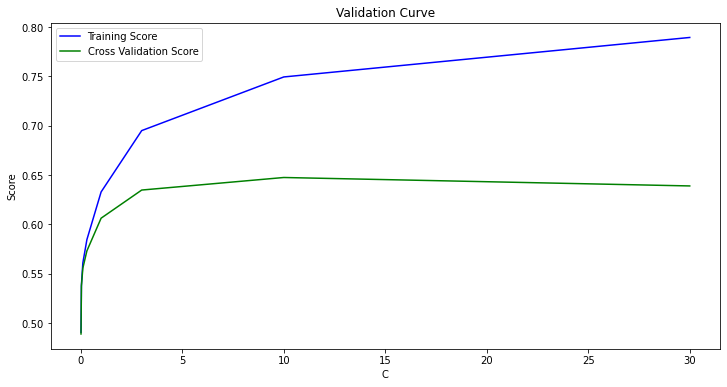

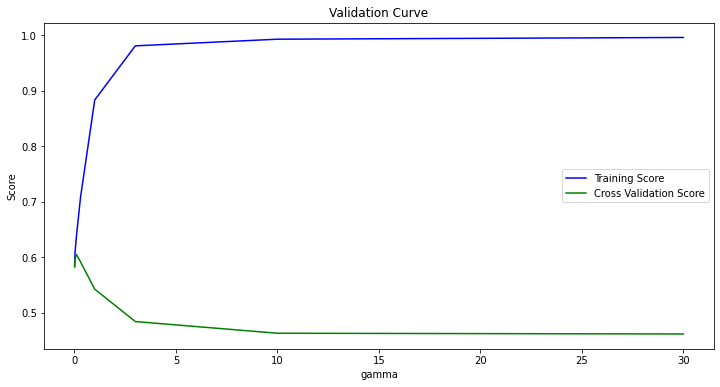

In [33]:
c_range = np.array([0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30])

val_curve_acc(c_range,"C", X_train, y_train.ravel())


val_curve_acc(c_range,"gamma", X_train, y_train.ravel())


# K-Fold CV

In [18]:
def kfold_test(X_train, y_train, X_test, y_test, clf, k):
    kf = KFold(n_splits=k, shuffle=True)
    
    scores = cross_validate(clf, X_train, y_train, scoring='accuracy', cv=k, return_estimator=True)

    avg_acc_score = sum(scores['test_score'])/k

    print('Accuracy of each fold - {}'.format(scores['test_score']))
    print('Avg accuracy : {}'.format(avg_acc_score))
    
    best_estimator = scores['estimator'][np.argmax(scores['test_score'])]

    y_pred_test = best_estimator.predict(X_test)
    acc_test = sum(y_test == y_pred_test) / float(len(y_pred_test))
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    print("Using the best estimator from CV:")
    print("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1_test , acc_test))
    
    return y_pred_test


## Optimal Logistic Regression with K-Fold CV

Accuracy of each fold - [0.62280702 0.64035088 0.61491228 0.64824561]
Avg accuracy : 0.631578947368421
Using the best estimator from CV:
F1 score and accuracy score for test set: 0.6108 , 0.6507.


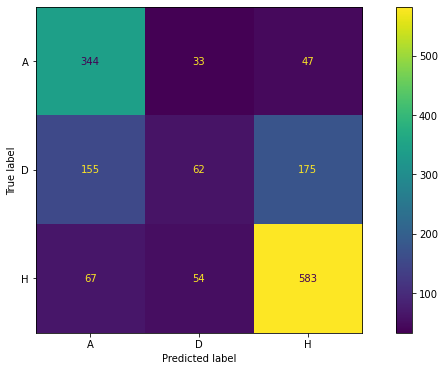

In [19]:
# Logistic Regression
y_pred_test = kfold_test(X_train, y_train, X_test, y_test, clf_log_opt, 4)
cm = get_confusion_matrix(clf_log_opt, y_pred_test, y_test)
display_cm(clf_log_opt, cm)

## Optimal SVM with K-Fold CV

Accuracy of each fold - [0.65       0.63947368 0.65       0.66140351]
Avg accuracy : 0.6502192982456141
Using the best estimator from CV:
F1 score and accuracy score for test set: 0.6640 , 0.6750.


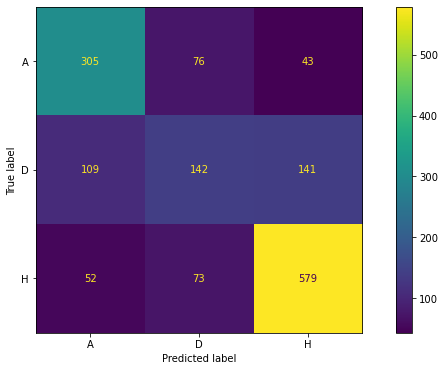

In [20]:
# SVM
y_pred_test = kfold_test(X_train, y_train, X_test, y_test, clf_svm_opt, 4)
cm = get_confusion_matrix(clf_svm_opt, y_pred_test, y_test)
display_cm(clf_svm_opt, cm)

## Optimal Neural Network with K-Fold CV

Accuracy of each fold - [0.65263158 0.65877193 0.65263158 0.67631579]
Avg accuracy : 0.6600877192982456
Using the best estimator from CV:
F1 score and accuracy score for test set: 0.6659 , 0.6862.


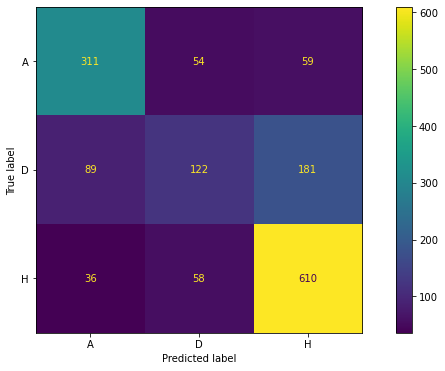

In [21]:
# NN
y_pred_test = kfold_test(X_train, y_train, X_test, y_test, clf_nn_opt, 4)
cm = get_confusion_matrix(clf_nn_opt, y_pred_test, y_test)
display_cm(clf_nn_opt, cm)

## Optimal XGBoost with K-Fold CV

/home/ruifmf/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/ruifmf/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Accuracy of each fold - [0.58947368 0.58596491 0.56929825 0.60175439]
Avg accuracy : 0.5866228070175439
Using the best estimator from CV:
F1 score and accuracy score for test set: 0.5953 , 0.6138.


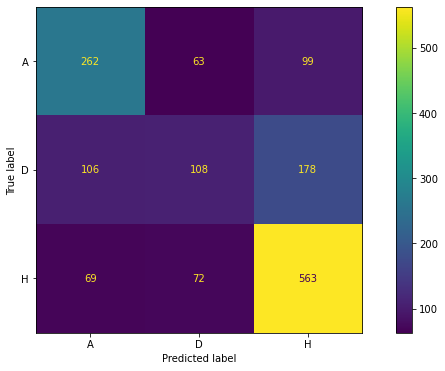

In [22]:
# XGBoost
y_pred_test = kfold_test(X_train, y_train, X_test, y_test, clf_xgb_opt, 4)
cm = get_confusion_matrix(clf_xgb_opt, y_pred_test, y_test)
display_cm(clf_xgb_opt, cm)
#extreme overfitting

# Ensemble Voting

Accuracy of each fold - [0.65263158 0.65350877 0.64210526 0.67017544]
Avg accuracy : 0.6546052631578948
Using the best estimator from CV:
F1 score and accuracy score for test set: 0.6543 , 0.6776.


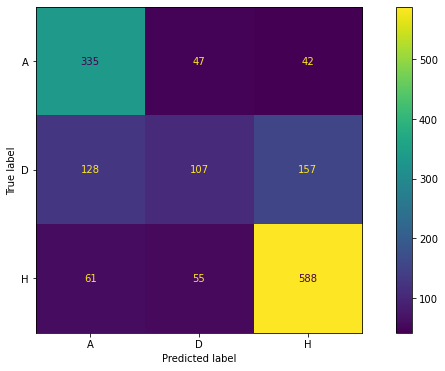

In [23]:
#Using voting method, droped the xgboost model because it was clearly lacking

eclf = VotingClassifier(estimators=[('mlp',clf_nn_opt), ('lr',clf_log_opt), ('svm', clf_svm_opt)], voting='hard')

y_pred_test = kfold_test(X_train, y_train, X_test, y_test, eclf, 4)
cm = get_confusion_matrix(clf_log, y_pred_test, y_test)
display_cm(clf_log, cm)

## With 3 of each model

Accuracy of each fold - [0.64736842 0.65789474 0.64035088 0.66491228]
Avg accuracy : 0.6526315789473685
Using the best estimator from CV:
F1 score and accuracy score for test set: 0.6529 , 0.6783.


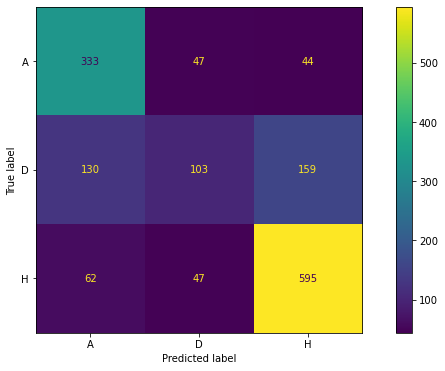

In [24]:
def gen_models():
    models = []
    for i in range(3):
        clf_nn_opt = MLPClassifier()
        clf_nn_opt.set_params(**best_nn_parameters[0])
        models.append(('mlp'+str(i), clf_nn_opt))

        clf_svm_opt = SVC()
        clf_svm_opt.set_params(**best_svm_parameters[0])
        models.append(('svm'+str(i), clf_svm_opt))

        clf_log_opt = LogisticRegression()
        clf_log_opt.set_params(**best_log_parameters[0])
        models.append(('lr'+str(i), clf_log_opt))

    return models

eclf_9model = VotingClassifier(estimators=gen_models(), voting='hard')

y_pred_test = kfold_test(X_train, y_train, X_test, y_test, eclf_9model, 4)
cm = get_confusion_matrix(clf_log, y_pred_test, y_test)
display_cm(clf_log, cm)

# Accuracy per class of final model

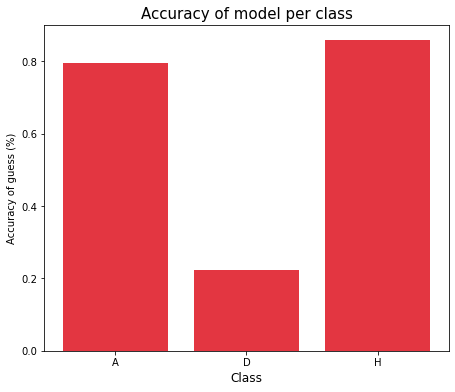

In [29]:
def class_acc(y_pred_test, X_train, X_test, y_train, y_test):
    cm = confusion_matrix(y_test, y_pred_test)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize = (7.25,6))
    plt.bar(['NH','H'], [cm[i][i] for i in range(2)], color="#e33641")
    plt.xlabel('Class',fontsize=12)
    plt.ylabel('Accuracy of guess (%)')
    plt.title('Accuracy of model per class',fontsize=15)
    plt.show()

class_acc(y_pred_test, X_train, X_test, y_train, y_test)